In [24]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
import os
from ChemUtils import GlobalStandardScaler, EmscScaler
import random
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
from sys import stdout
from scipy.stats import f
from sklearn.model_selection import cross_val_predict
import obspy
from obspy.signal.detrend import polynomial
import seaborn as sns 
import scipy.io as sio
from joblib import load
import peval 

import tensorflow as tf
from livelossplot import PlotLossesKerasTF
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


In [25]:
# read in the data from the pickle file
with open('/root/autodl-tmp/vertigo/data/2_outlier_removal.pkl', 'rb') as f:
    df = pickle.load(f)

with open('/root/autodl-tmp/vertigo/data/2_clean_data.pkl', 'rb') as f:
    df_clean = pickle.load(f)

with open('/root/autodl-tmp/vertigo/data/2_outlier_removal_pls.pkl', 'rb') as f:
    df_clean_pls = pickle.load(f)

df = df_clean.copy()

Prepare Data

In [26]:
# Separate spectral data and quality attributes
spectral_cols = [col for col in df.columns if 'GHz' in col]
quality_attrs = ['Brix', 'TA', 'Firmness (kg)']

X = df[spectral_cols]
y = df[quality_attrs]
y_brix = df['Brix']
y_TA = df['TA']
y_firmness = df['Firmness (kg)']

# train: val: test = 7:1:2
# Split data into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

# Split temp into validation (10%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, shuffle=True
)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)
x_val_scaled = scaler.transform(X_val)


# Separate and scale targets
y_train_orig = y_train.copy()
y_val_orig = y_val.copy()
y_test_orig = y_test.copy()

# Initialize scalers for each target
target_scalers = {
    'brix': StandardScaler(),
    'ta': StandardScaler(),
    'firmness': StandardScaler()
}

# Scale training targets
y_train_scaled = pd.DataFrame({
    'Brix': target_scalers['brix'].fit_transform(y_train[['Brix']]).flatten(),
    'TA': target_scalers['ta'].fit_transform(y_train[['TA']]).flatten(),
    'Firmness (kg)': target_scalers['firmness'].fit_transform(y_train[['Firmness (kg)']]).flatten()
})

# Scale validation/test using training statistics
y_val_scaled = pd.DataFrame({
    'Brix': target_scalers['brix'].transform(y_val[['Brix']]).flatten(),
    'TA': target_scalers['ta'].transform(y_val[['TA']]).flatten(),
    'Firmness (kg)': target_scalers['firmness'].transform(y_val[['Firmness (kg)']]).flatten()
})

y_test_scaled = pd.DataFrame({
    'Brix': target_scalers['brix'].transform(y_test[['Brix']]).flatten(),
    'TA': target_scalers['ta'].transform(y_test[['TA']]).flatten(),
    'Firmness (kg)': target_scalers['firmness'].transform(y_test[['Firmness (kg)']]).flatten()
})


# Set random seeds
def reproducible_comp():
    SEED_VALUE = 42
    os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    tf.keras.backend.clear_session()

* ANN

In [27]:
# set random seeds for Python, NumPy, and TensorFlow
SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [28]:
# clear keras session
tf.keras.backend.clear_session()

# number of sample to train for each pass into the ANN
batch = 128

# learning rate
lr = 0.01*batch/256.

# input layer dimensions
input_dims = x_train_scaled.shape[1]
# print(f"Input dimensions: {input_dims}")

# model architecture
ann_model = tf.keras.models.Sequential(
    layers=[
        # single hidden layer with 5 neurons
        tf.keras.layers.Dense(units=5, activation="sigmoid", input_dim=input_dims),

        # linear output layer
        tf.keras.layers.Dense(units=1, activation="linear"),
    ]
)

# compile model with adam optimiser
ann_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="mse",
    metrics=["mse"]
)

# reduce learning rate dynamically
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=25,
    factor=0.5,
    min_lr=10**-6,
    monitor="loss",
    verbose=0
)

# early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=10**(-2.5),
    patience=200,
    mode="auto",
    restore_best_weights=True
)

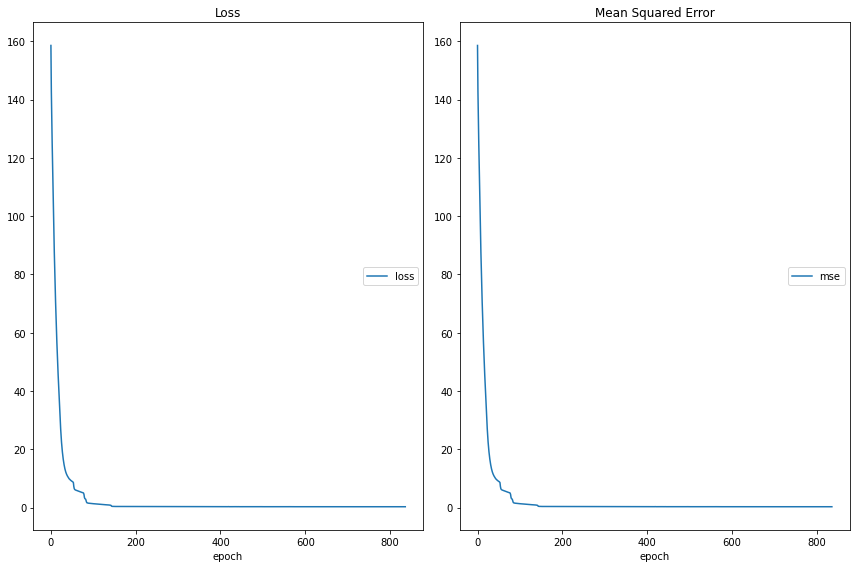

Loss
	loss             	 (min:    0.320, max:  158.554, cur:    0.320)
Mean Squared Error
	mse              	 (min:    0.320, max:  158.554, cur:    0.320)
14/14 [==============================] - 0s 16ms/step - loss: 0.3201 - mse: 0.3201 - lr: 7.8125e-05


In [29]:
plot_losses = PlotLossesKerasTF()

# train the model
history = ann_model.fit(
    x=x_train_scaled,
    # y=y_train,
    y=y_train_orig['Brix'],
    batch_size=batch,
    epochs=1000,
    callbacks=[plot_losses, reduce_lr, early_stopping],
    verbose=1
)

# save the model

# ann_model.save('/root/autodl-tmp/vertigo/ta_models/df_clean_pls/ann_model.h5')
# ann_model.save('/root/autodl-tmp/vertigo/frim_models/df_clean_pls/ann_model.h5')
ann_model.save('/root/autodl-tmp/vertigo/brix_models/df_clean/ann_model.h5')

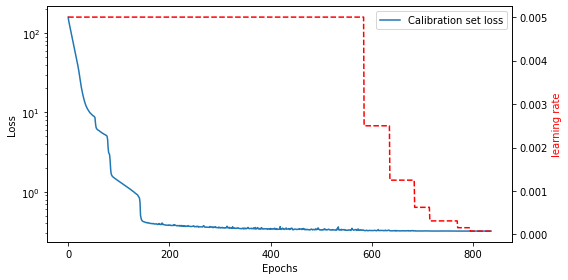

In [30]:
peval.plot_model_history(history.history)

53/53 [==============================] - 0s 784us/step


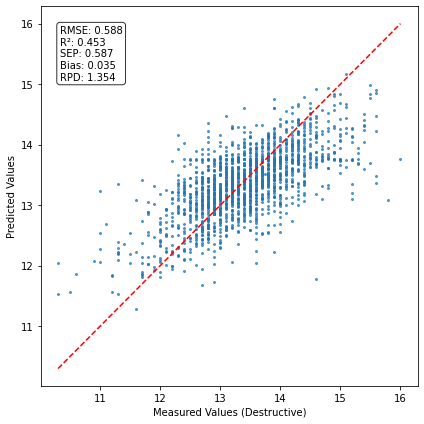

{'r2': 0.45302679758572395, 'rmse': 0.5876567439840993, 'sep': 0.5868059119684207, 'bias': 0.03468287925336715, 'rpd': 1.3544864678491106}
16/16 [==============================] - 0s 920us/step


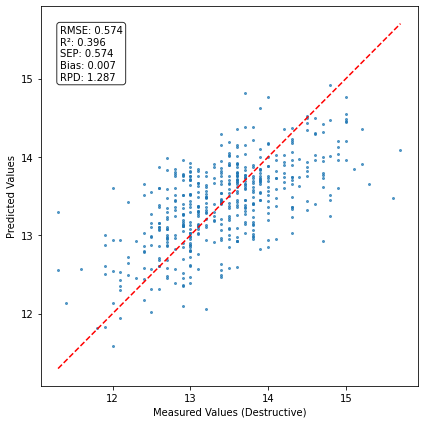

{'r2': 0.396442025583434, 'rmse': 0.5738699132000705, 'sep': 0.5744244928885731, 'bias': 0.006702388416637052, 'rpd': 1.2872714164400232}


In [39]:
# load the model
# ann_model = tf.keras.models.load_model('/root/autodl-tmp/vertigo/ta_models/df_clean_pls/ann_model.h5')
# ann_model = tf.keras.models.load_model('/root/autodl-tmp/vertigo/frim_models/df_clean_pls/ann_model.h5')
ann_model = tf.keras.models.load_model('/root/autodl-tmp/vertigo/brix_models/df_clean_pls/ann_model.h5')

# calculate metrics for training set (in original scale)
y_train_pred_scaled = ann_model.predict(x_train_scaled).flatten()
# y_train_pred = target_scalers['brix'].inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
ann_metrics_train = peval.calculate_metrics(y_true=y_train_orig['Brix'], y_pred=y_train_pred_scaled)
print(ann_metrics_train)

# calculate metrics for test set (in original scale)
y_test_pred_scaled = ann_model.predict(x_test_scaled).flatten()
# y_test_pred = target_scalers['brix'].inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()
ann_metrics_test = peval.calculate_metrics(y_true=y_test_orig['Brix'], y_pred=y_test_pred_scaled)
print(ann_metrics_test)

* CNN_01

In [32]:
plot_losses = PlotLossesKerasTF()

# Reshape data for Conv1D (samples, timesteps, features)
# We have 56 frequencies (real+imaginary = 112 features)
X_train_reshaped = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
X_val_reshaped = x_val_scaled.reshape(x_val_scaled.shape[0], x_val_scaled.shape[1], 1)
X_test_reshaped = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

# Model parameters
batch = 128
lr = 0.01 * batch / 256.
input_dims = x_train_scaled.shape[1]  # Should be 112 (56 real + 56 imaginary)

# Simple CNN model for Brix prediction
cnn_model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.InputLayer(input_shape=(input_dims, 1)),
    
    # First Conv1D layer with small kernel to capture local patterns
    tf.keras.layers.Conv1D(
        filters=16,  # Small number of filters to prevent overfitting
        kernel_size=5,  # Looks at 5 frequency points at a time
        strides=1,
        padding='same',
        activation='elu',
        kernel_initializer=tf.keras.initializers.HeNormal(seed=42),
        kernel_regularizer=tf.keras.regularizers.l2(0.001)  # L2 regularization
    ),
    tf.keras.layers.BatchNormalization(),
    
    # Pooling to reduce dimensionality
    tf.keras.layers.MaxPooling1D(pool_size=2),
    
    # Second Conv1D layer
    tf.keras.layers.Conv1D(
        filters=32,
        kernel_size=3,
        strides=1,
        padding='same',
        activation='elu',
        kernel_initializer=tf.keras.initializers.HeNormal(seed=42),
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.BatchNormalization(),
    
    # Global pooling instead of flattening to reduce parameters
    tf.keras.layers.GlobalAveragePooling1D(),
    
    # Single dense layer
    tf.keras.layers.Dense(
        units=16,
        activation='elu',
        kernel_initializer=tf.keras.initializers.HeNormal(seed=42),
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    tf.keras.layers.Dropout(0.1),  # Additional regularization
    
    # Output layer
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile model
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="mse",
    metrics=["mse"]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=25,
        factor=0.5,
        min_lr=10**-6,
        monitor="val_loss",
        verbose=0
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=10**(-2.5),
        patience=200,
        restore_best_weights=True
    )
]


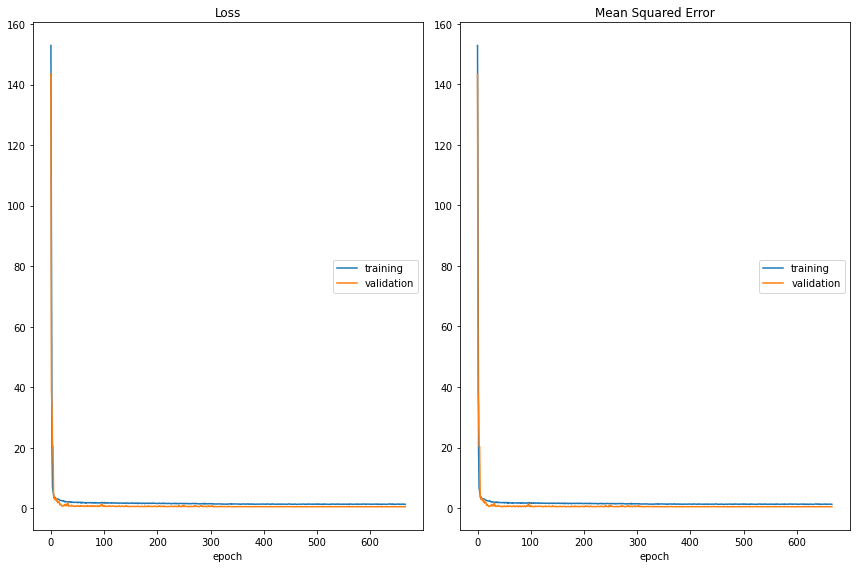

Loss
	training         	 (min:    1.212, max:  152.951, cur:    1.306)
	validation       	 (min:    0.506, max:  143.523, cur:    0.510)
Mean Squared Error
	training         	 (min:    1.147, max:  152.827, cur:    1.241)
	validation       	 (min:    0.440, max:  143.394, cur:    0.445)


In [33]:
# Train model
history = cnn_model.fit(
    x=X_train_reshaped,
    y=y_train_orig['Brix'],
    batch_size=batch,
    epochs=800,
    validation_data=(X_val_reshaped, y_val_orig['Brix']),
    callbacks=[plot_losses, callbacks],
    verbose=0,
    shuffle=True
)

# save the model
cnn_model.save('/root/autodl-tmp/vertigo/brix_models/df_clean/cnn_model_01.h5')
# cnn_model.save('/root/autodl-tmp/vertigo/ta_models/df_clean_pls/cnn_model_01.h5')
# cnn_model.save('/root/autodl-tmp/vertigo/frim_models/df_clean_pls/cnn_model_01.h5')


53/53 [==============================] - 0s 2ms/step


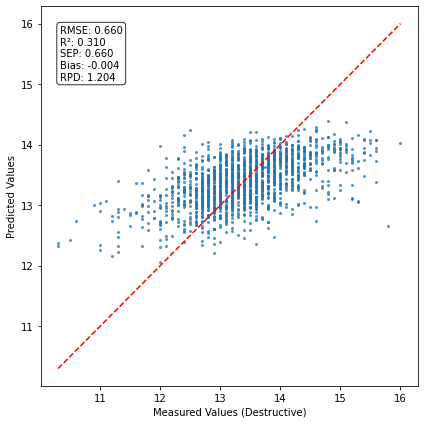

{'r2': 0.310053697226199, 'rmse': 0.6600067019197585, 'sep': 0.6601918694705551, 'bias': -0.003645670511255872, 'rpd': 1.2039237436421226}
16/16 [==============================] - 0s 2ms/step


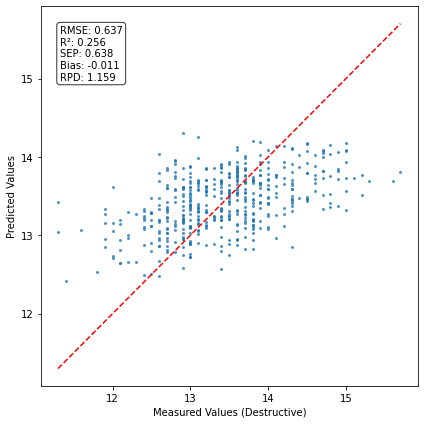

{'r2': 0.25560099983071294, 'rmse': 0.6373189773457368, 'sep': 0.63788637996751, 'bias': -0.010823383016034612, 'rpd': 1.159203666703431}


In [34]:
# load the model
cnn_model = tf.keras.models.load_model('/root/autodl-tmp/vertigo/brix_models/df_clean/cnn_model_01.h5')
# cnn_model = tf.keras.models.load_model('/root/autodl-tmp/vertigo/ta_models/df_clean/cnn_model_01.h5')
# cnn_model = tf.keras.models.load_model('/root/autodl-tmp/vertigo/frim_models/df_clean_pls/cnn_model_01.h5')

# calculate metrics for training set
y_train_pred = cnn_model.predict(X_train_reshaped).flatten()
cnn_metrics_train = peval.calculate_metrics(y_true=y_train_orig['Brix'], y_pred=y_train_pred)
print(cnn_metrics_train)
y_test_pred = cnn_model.predict(X_test_reshaped).flatten()
cnn_metrics_test = peval.calculate_metrics(y_true=y_test_orig['Brix'], y_pred=y_test_pred)
print(cnn_metrics_test)


* CNN 02

In [35]:
## Make computations reproducible
reproducible_comp()
plot_losses = PlotLossesKerasTF()

## Layers dimensions
INPUT_DIMS = np.shape(X_train)[1]
CONV1D_DIMS = INPUT_DIMS
K_NUMBER = 1
K_WIDTH = 5
K_STRIDE = 1
FC1_DIMS = 36
FC2_DIMS = 18
FC3_DIMS = 12
OUT_DIMS = 1


## L2 regularizer parameter
beta= 0.003/2.

## For the sake of simplicity we do the weights initialization for multiple layers here
## Due to this, we might have to re-run this cell before each experiment to ensure proper weight initialization each time
K_INIT = tf.keras.initializers.he_normal(seed=42)

## Weights L2 regularization 
K_REG = tf.keras.regularizers.l2(beta)


model_cnn_02 = keras.Sequential([  keras.layers.Reshape((INPUT_DIMS, 1),input_shape=(INPUT_DIMS,)), \
                                keras.layers.Conv1D(filters=K_NUMBER, \
                                                    kernel_size=K_WIDTH, \
                                                    strides=K_STRIDE, \
                                                    padding='same', \
                                                    kernel_initializer=K_INIT,\
                                                    kernel_regularizer=K_REG,\
                                                    activation='elu',\
                                                    input_shape=(CONV1D_DIMS,1)), \
                                keras.layers.Flatten(),
                                keras.layers.Dense(FC1_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu'),
                                keras.layers.Dense(FC2_DIMS, \
                                                   kernel_initializer=K_INIT,\
                                                   kernel_regularizer=K_REG,\
                                                   activation='elu'),
                                keras.layers.Dense(FC3_DIMS, \
                                                   kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG, \
                                                   activation='elu'),
                                keras.layers.Dense(1, kernel_initializer=K_INIT, \
                                                   kernel_regularizer=K_REG,\
                                                   activation='linear'),
                              ])

print(model_cnn_02.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 112, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 112, 1)            6         
                                                                 
 flatten (Flatten)           (None, 112)               0         
                                                                 
 dense (Dense)               (None, 36)                4068      
                                                                 
 dense_1 (Dense)             (None, 18)                666       
                                                                 
 dense_2 (Dense)             (None, 12)                228       
                                                                 
 dense_3 (Dense)             (None, 1)                 1

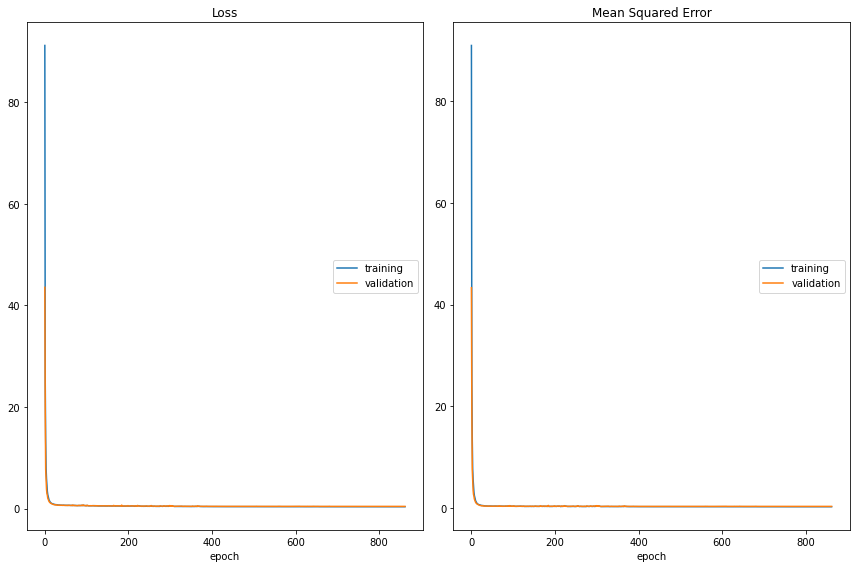

Loss
	training         	 (min:    0.368, max:   91.148, cur:    0.369)
	validation       	 (min:    0.433, max:   43.554, cur:    0.434)
Mean Squared Error
	training         	 (min:    0.285, max:   90.940, cur:    0.285)
	validation       	 (min:    0.342, max:   43.331, cur:    0.351)

Epoch 863: val_loss did not improve from 0.43328


In [36]:
##### TRAIN MODEL WITH ADAM OPTIMIZER #########
BATCH=256    
LR=0.01*BATCH/256.

print('Adam learning rate = {}'.format(LR))
model_cnn_02.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='mse', metrics=['mse'])  

#### We can play around with different the following methods to check for improvements. In this base notebook only checkpoint is used! 
### 1) Stop the training if it does not improve
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=200, mode='auto', restore_best_weights=True)
#
### 2) Reduce learning rate dynamically
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=0)
### 3) Save the best weights into file
# checkpointer= keras.callbacks.ModelCheckpoint(filepath="/root/autodl-tmp/vertigo/ta_models/df_clean_pls/cnn_model_02.h5", verbose=1, save_best_only=True)
checkpointer= keras.callbacks.ModelCheckpoint(filepath="/root/autodl-tmp/vertigo/brix_models/df_clean/cnn_model_02.h5", verbose=1, save_best_only=True)
# checkpointer= keras.callbacks.ModelCheckpoint(filepath="/root/autodl-tmp/vertigo/frim_models/df_clean_pls/cnn_model_02.h5", verbose=1, save_best_only=True)
## Train the model
h1=model_cnn_02.fit(x_train_scaled, y_train_orig['Brix'], batch_size=BATCH, epochs=1000, \
          validation_data=(x_val_scaled, y_val_orig['Brix']),  \
          callbacks=[plot_losses, checkpointer, early_stop, rdlr],verbose=0)

tf.keras.backend.clear_session()

53/53 [==============================] - 0s 1ms/step


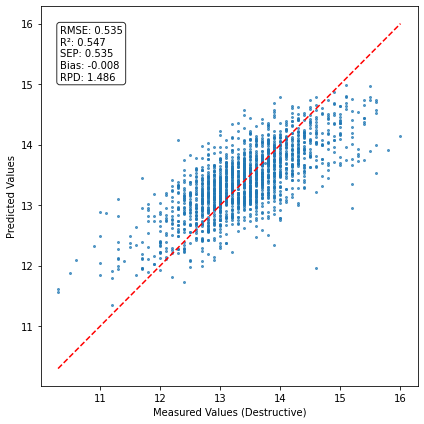

{'r2': 0.5472478026055335, 'rmse': 0.5346517381699852, 'sep': 0.5347533059833032, 'bias': -0.007777567411723884, 'rpd': 1.4863314693371887}
16/16 [==============================] - 0s 2ms/step


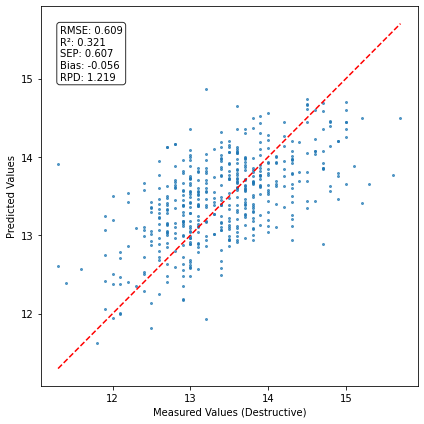

{'r2': 0.321214384436457, 'rmse': 0.6085836425151766, 'sep': 0.6065930080870354, 'bias': -0.05638448581222662, 'rpd': 1.2190055288148307}


In [37]:
# load the model
# cnn_model_02 = tf.keras.models.load_model('/root/autodl-tmp/vertigo/ta_models/df_clean_pls/cnn_model_02.h5')
cnn_model_02 = tf.keras.models.load_model('/root/autodl-tmp/vertigo/brix_models/df_clean/cnn_model_02.h5')
# cnn_model_02 = tf.keras.models.load_model('/root/autodl-tmp/vertigo/frim_models/df_clean_pls/cnn_model_02.h5')
# calculate metrics for training set
y_train_pred = cnn_model_02.predict(x_train_scaled).flatten()
cnn_metrics_train = peval.calculate_metrics(y_true=y_train_orig['Brix'], y_pred=y_train_pred)
print(cnn_metrics_train)
y_test_pred = cnn_model_02.predict(x_test_scaled).flatten()
cnn_metrics_test = peval.calculate_metrics(y_true=y_test_orig['Brix'], y_pred=y_test_pred)
print(cnn_metrics_test)
